In [1]:
import pandas as pd

In [387]:
monthly_df = pd.read_csv('./Monthly_.csv',index_col=0)
monthly_df = monthly_df.T
monthly_df.index = pd.to_datetime(monthly_df.index)
monthly_df = monthly_df[2:]
monthly_df.columns = ["kentikukakuninzumi_kensa_kensu",
"tyukan_kensa_kensu",
"kanryo_kensa_kensu",
"sekkei_seinou_hyouka_sintiku_kodate_kensu",
"sekkei_seinou_hyouka_sintiku_kyoudo_kensu",
"kensetu_seinou_hyouka_sintiku_kodate_kensu",
"kensetu_seinou_hyouka_sintiku_kyodo_kensu",]

In [388]:
for j in monthly_df.columns:
    for i in range(1,3):
        monthly_df[f'{j}-{i}'] = monthly_df[f'{j}'].shift(-i)
    
    monthly_df[f'{j}_mean'] = monthly_df[[f'{j}',f'{j}-1',f'{j}-2']].mean(axis='columns')
    monthly_df = monthly_df.drop([f'{j}-1',f'{j}-2'],axis=1)


In [389]:
# 6-9,10-12...の件数のdf
monthly_df = monthly_df[3::3]
monthly_df = monthly_df[["kentikukakuninzumi_kensa_kensu_mean",
	"tyukan_kensa_kensu_mean",
	"kanryo_kensa_kensu_mean",
	"sekkei_seinou_hyouka_sintiku_kodate_kensu_mean",
	"sekkei_seinou_hyouka_sintiku_kyoudo_kensu_mean",
	"kensetu_seinou_hyouka_sintiku_kodate_kensu_mean",
	"kensetu_seinou_hyouka_sintiku_kyodo_kensu_mean",]]

monthly_df = monthly_df.dropna()

monthly_kakunin = monthly_df[["kentikukakuninzumi_kensa_kensu_mean",
	"tyukan_kensa_kensu_mean",
	"kanryo_kensa_kensu_mean",]]

monthly_sekkei = monthly_df[["sekkei_seinou_hyouka_sintiku_kodate_kensu_mean",
	"sekkei_seinou_hyouka_sintiku_kyoudo_kensu_mean",
	"kensetu_seinou_hyouka_sintiku_kodate_kensu_mean",
	"kensetu_seinou_hyouka_sintiku_kyodo_kensu_mean",]]

kakunin_train = monthly_kakunin[:-1]
sekkei_train = monthly_sekkei[:-1]

In [375]:
kakunin_sales = pd.read_csv('./kakunin_sales.csv',index_col=0)[["2021/05","2022/05",]]
seinouhyouka_sales = pd.read_csv('./seinouhyouka_sales.csv',index_col=0)[["2021/05","2022/05",]]

for i,j in enumerate(kakunin_sales.columns):
    if i>0:
        tmp = pd.concat([tmp,kakunin_sales[f"{j}"]],axis=0)
    else:
        tmp = kakunin_sales[f"{j}"]
kakunin_y = pd.DataFrame(tmp.copy().reset_index(drop=True))

for i,j in enumerate(seinouhyouka_sales.columns):
    if i>0:
        tmp = pd.concat([tmp,seinouhyouka_sales[f"{j}"]],axis=0)
    else:
        tmp = kakunin_sales[f"{j}"]
seinouhyouka_y = pd.DataFrame(tmp.copy().reset_index(drop=True))

In [379]:
lgbm_params = {"objective": "regression",
        "learning_rate": 0.2,
        "boosting_type": "gbdt",
        "min_data_in_leaf":600,
        "max_bin": 196,
        "feature_fraction":0.4,
        "lambda_l1":36, "lambda_l2":80,
        "max_depth":10,
        "num_leaves":1000,
        "metric": "rmse",
        "tree_learner": "voting",
        "seed": 71
    }

In [390]:
kakunin_train.shape,kakunin_y.shape,sekkei_train.shape,seinouhyouka_y.shape

((8, 3), (8, 1), (8, 4), (8, 1))

In [398]:
lgb_train = lgb.Dataset(kakunin_train, kakunin_y)
# lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
model = lgb.train(lgbm_params,lgb_train)

pred_train = model.predict(kakunin_train, num_iteration=model.best_iteration)
pred_y = model.predict(monthly_kakunin[-1:], num_iteration=model.best_iteration)


[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] Start training from score 5112.375000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Light

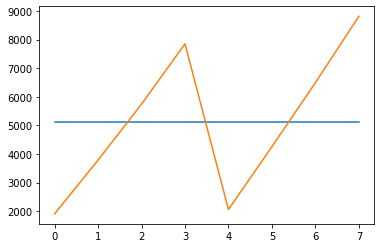

In [400]:
import matplotlib.pyplot as plt
plt.plot(pred_train)
plt.plot(kakunin_y)


In [402]:
lgb_train = lgb.Dataset(sekkei_train, seinouhyouka_y)
model = lgb.train(lgbm_params,lgb_train)
pred_train = model.predict(sekkei_train, num_iteration=model.best_iteration)
pred_y = model.predict(monthly_sekkei[-1:], num_iteration=model.best_iteration)


[LightGBM] [Warning] There are no meaningful features, as all feature values are constant.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 8, number of used features: 0
[LightGBM] [Info] Start training from score 3590.375000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Light

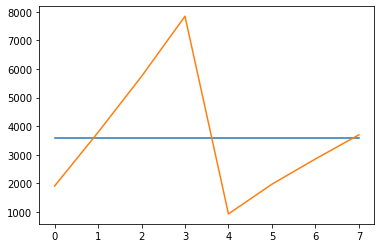

In [403]:
import matplotlib.pyplot as plt
plt.plot(pred_train)
plt.plot(seinouhyouka_y)
